# 5장. 시장 모니터링 및 수시 리밸런싱

In [1]:
from sympy.physics.control.control_plots import matplotlib
%load_ext autoreload
%autoreload

In [2]:
from typing import Dict, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pypfopt import EfficientFrontier
import plotly.graph_objects as go
import exchange_calendars as ec

from simulation.account import Account
from simulation.broker import Broker
# from monitoring.technical_indicator import rsi, adr, macd
from data.data_loader import PykrxDataLoader
from simulation.utility import ticker_to_name, get_lookback_fromdate
from simulation.utility import rebalance
from simulation.metric import cagr, mdd, sharpe_ratio, sortino_ratio
from simulation.visualize import plot_cumulative_return


## 1. 평균-분산 전략 구현

### 1.1. 평균-분산 최적화

In [3]:
# Relative Strength Index 상대 강도 지수
def rsi(df: pd.DataFrame, window_length: int = 14):
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
    avg_loss = loss.rolling(window=window_length, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 * rs / (1+rs)

    return rsi

# Advanced Decline Ratio 등락 비율
def adr(df: pd.DataFrame, window_length: int = 20):
    ups = df.groupby('date')['change_pct'].apply(lambda x: (x>0).sum())
    downs = df.groupby('date')['change_pct'].apply(lambda x: (x<0).sum())

    sum_of_ups = ups.rolling(window=window_length, min_periods=1).sum()
    sum_of_downs = downs.rolling(window=window_length, min_periods=1).sum()
    adr = (sum_of_ups / sum_of_downs) * 100

    return adr

# Moving Average Convergence Divergence 이동 평균 수렴 확산
def macd(df: pd.DataFrame, window_length: tuple = (12, 26)):
    ma1 = df['close'].ewm(span=window_length[0]).mean()
    ma2 = df['close'].ewm(span=window_length[1]).mean()
    macd = ma1 - ma2 # MaCD
    macds = macd.ewm(span=9).mean() # Signal
    macdh = macd - macds # Histogram

    return macdh

In [4]:
def get_month_end(start_date, end_date) -> pd.DatetimeIndex:
    # KRX(한국거래소)의 거래 캘링더.
    calendar = ec.get_calendar('XKRX')

    # 특정 기간 동안의 거래 세션을 가져옴.
    sessions = calendar.sessions_in_range(start_date, end_date)

    # DateFrame의 범위 내에서 가능한 모든 월말 날짜를 생성.
    all_month_ends = pd.date_range(start=start_date, end=end_date, freq='M')

    # 각 월말 이전의 마지막 거래일 (또는 월말이 거래일인 경우 그 날)을 가져옴.
    last_business_day = [sessions[sessions <= date][-1] for date in all_month_ends]

    return last_business_day

In [5]:
def simulate_market_monitoring_etf(ohlcv_data: pd.DataFrame,
                                   monitoring_data: pd.DataFrame) -> Account:
    account = Account(initial_cash=100000000)
    broker = Broker()
    rebalance_date = monitoring_data[monitoring_data['signal'] != monitoring_data['signal'].shift(1)].index.tolist()
    month_end = get_month_end(kospi_data.index.min(), kospi_data.index.max())
    rebalance_date += month_end

    for date, ohlcv in ohlcv_data.groupby('date'):
        transactions = broker.process_order(dt=date, data=ohlcv,
                                            orders=account.orders)
        account.update_position(transactions=transactions)
        account.update_portfolio(dt=date, data=ohlcv)
        account.update_order()

        if date not in rebalance_date:
            continue
        print(date.date())

        signal = monitoring_data.loc[date]['signal']

        if signal == 'rise':
            weights = {'122630': 1,
                       '069500': 0,
                       '252670': 0}
        elif signal == 'keep':
            weights = {'122630': 0,
                       '069500': 1,
                       '252670': 0}
        elif signal == 'decline':
            weights = {'122630': 0,
                       '069500': 0,
                       '252670': 1}

        print(f'Portfolio: {weights}')
        if weights is None:
            continue

        rebalance(dt=date, data=ohlcv, account=account, weights=weights)

    return account


In [27]:
def calculate_rsi_signal(indicator) -> str:
    if indicator >= 60:
        signal = 'rise'
    elif indicator <= 30:
        signal = 'decline'
    else:
        signal = 'keep'

    return signal

def calculate_adr_signal(indicator) -> str:
    if indicator >= 110:
        signal = 'rise'
    elif indicator <= 80:
        signal = 'decline'
    else:
        signal = 'keep'

    return signal


In [7]:
fromdate = '2020-01-01'
todate = '2020-12-31'
ticker_list = ['122630', #코스피 2배
               '069500', #코스피 추종
               '252670', #코스피 인버스
               ]

data_loader = PykrxDataLoader(fromdate=fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_etf_data(ticker_list=ticker_list, freq='d', delay=1)
ohlcv_data.head()

,nav,open,high,low,close,volume,trading_value,benchmark,ticker
date,,,,,,,,,
2020-01-02,14086.49,14425,14470,14015,14060,12770663,180796400445,290.35,122630
2020-01-03,14131.32,14305,14465,13910,14070,22193579,315028517570,290.74,122630
2020-01-06,13900.44,13820,13950,13785,13840,11065698,153421992880,288.43,122630
2020-01-07,14198.44,13990,14230,13955,14115,12317210,173974477995,291.23,122630
2020-01-08,14000.26,13905,14090,13750,13955,15903202,221123894400,289.42,122630


In [8]:
monitoring_ticker_list = ['1001']

kospi_data = data_loader.load_index_data(ticker_list=monitoring_ticker_list, freq='d', delay=1)
kospi_data.head()

코스피,open,high,low,close,volume,trading_value,market_cap,ticker
date,,,,,,,,
2020-01-02,2201.21,2202.32,2171.84,2175.17,494677752,4638167309579,1461424793589993,1001
2020-01-03,2192.58,2203.38,2165.39,2176.46,631562785,5763662746548,1462298971774498,1001
2020-01-06,2154.97,2164.42,2149.95,2155.07,592670719,5156540935534,1448385085188395,1001
2020-01-07,2166.60,2181.62,2164.27,2175.54,568235609,5143511908278,1462298814406954,1001
2020-01-08,2156.27,2162.32,2137.72,2151.31,913830628,8750722208310,1446631314388659,1001


In [9]:

kospi_data['rsi'] = rsi(kospi_data).bfill()
kospi_data.head()

코스피,open,high,low,close,volume,trading_value,market_cap,ticker,rsi
date,,,,,,,,,
2020-01-02,2201.21,2202.32,2171.84,2175.17,494677752,4638167309579,1461424793589993,1001,5.687831
2020-01-03,2192.58,2203.38,2165.39,2176.46,631562785,5763662746548,1462298971774498,1001,5.687831
2020-01-06,2154.97,2164.42,2149.95,2155.07,592670719,5156540935534,1448385085188395,1001,5.687831
2020-01-07,2166.60,2181.62,2164.27,2175.54,568235609,5143511908278,1462298814406954,1001,50.428737
2020-01-08,2156.27,2162.32,2137.72,2151.31,913830628,8750722208310,1446631314388659,1001,32.294449


/opt/anaconda3/envs/pyra312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pyra312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


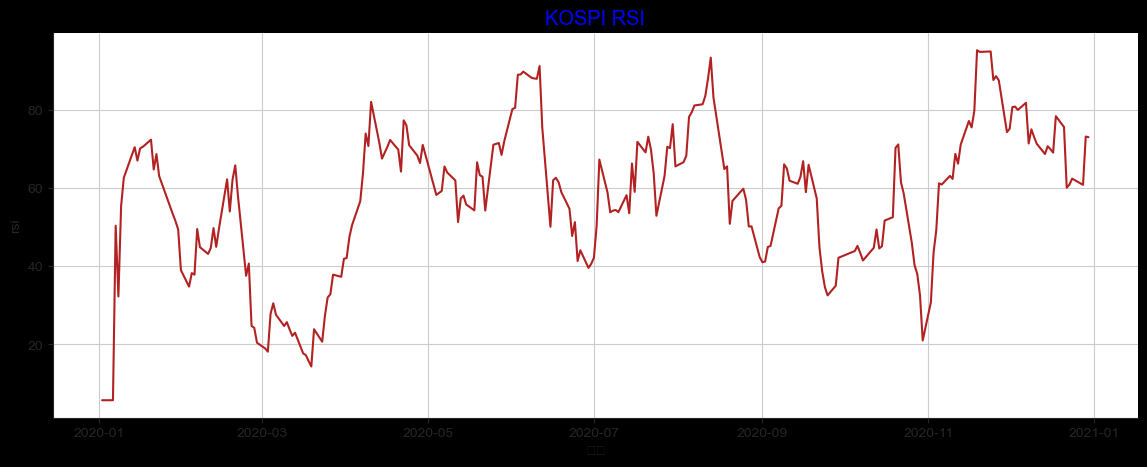

In [10]:
import platform
os_system = platform.system()
# 시스템에 따라 폰트 설정
if os_system == 'Windows':
    font_name = 'Malgun Gothic'
elif os_system == 'Darwin':
    font_name = 'AppleGothic'
else:
    font_name = 'Arial'
plt.rc('font', family=font_name)

plt.figure(figsize=(14,5))
sns.set_style('ticks')
sns.lineplot(data=kospi_data, x='date', y='rsi', color='firebrick').set_xlabel('날짜')
sns.despine()
plt.title('KOSPI RSI', size='x-large', color='blue')
plt.grid()
plt.show()

In [11]:
kospi_data['signal'] = kospi_data['rsi'].apply(calculate_rsi_signal)
kospi_data.head()

코스피,open,high,low,close,volume,trading_value,market_cap,ticker,rsi,signal
date,,,,,,,,,,
2020-01-02,2201.21,2202.32,2171.84,2175.17,494677752,4638167309579,1461424793589993,1001,5.687831,decline
2020-01-03,2192.58,2203.38,2165.39,2176.46,631562785,5763662746548,1462298971774498,1001,5.687831,decline
2020-01-06,2154.97,2164.42,2149.95,2155.07,592670719,5156540935534,1448385085188395,1001,5.687831,decline
2020-01-07,2166.60,2181.62,2164.27,2175.54,568235609,5143511908278,1462298814406954,1001,50.428737,keep
2020-01-08,2156.27,2162.32,2137.72,2151.31,913830628,8750722208310,1446631314388659,1001,32.294449,keep


In [12]:
simulation_account = simulate_market_monitoring_etf(ohlcv_data=ohlcv_data, monitoring_data=kospi_data)

/var/folders/rk/v4lbk0_j1l5ddg0wmz4352880000gn/T/ipykernel_14258/1604795691.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_month_ends = pd.date_range(start=start_date, end=end_date, freq='M')


2020-01-02
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-01-07
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-01-10
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-01-28
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-01-31
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-02-17
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-02-18
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-02-19
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-02-21
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-02-26
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-02-28
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-03-05
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-03-06
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-03-25
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-03-31
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-04-07
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-04-

In [13]:
df_account = pd.DataFrame(simulation_account.account_history).set_index('date')
df_portfolio = pd.DataFrame(simulation_account.portfolio_history).set_index('date')
df_portfolio = df_portfolio.assign(ticker=df_portfolio['ticker'].apply(lambda x: f'{x}({ticker_to_name(x)}'))

In [14]:
returns = df_account['total_asset'].pct_change()
returns.name = 'return'

In [15]:
kospi = data_loader.load_index_data(ticker_list=['1001'], freq='d', delay=1)
kospi_returns = kospi['close'].pct_change()
kospi_returns.iloc[0] = 0.0
kospi_returns.name = 'kospi-return'
kospi_returns.index.name = 'date'

In [16]:
pd.concat([returns, kospi_returns], axis=1)

,return,kospi-return
date,,
2020-01-02,NaN,0.000000
2020-01-03,0.019571,0.000593
2020-01-06,0.014089,-0.009828
2020-01-07,-0.020840,0.009499
2020-01-08,0.012987,-0.011137
...,...,...
2020-12-23,0.026685,0.009562
2020-12-24,0.037061,0.017045
2020-12-28,0.011835,0.000620


In [17]:
print(f'연평균 복리 성장률(Compound Annual Growth Rate) RSI 전략: {cagr(returns=returns, freq='d'): .3f}')
print(f'연평균 복리 성장률(Compound Annual Growth Rate) 코스피: {cagr(returns=kospi_returns, freq='d'): .3f}')

연평균 복리 성장률(Compound Annual Growth Rate) RSI 전략:  1.052
연평균 복리 성장률(Compound Annual Growth Rate) 코스피:  0.327


In [18]:
print(f'mdd(Maximum Drawdown, 최대 손실 낙폭) RSI 전략: {mdd(returns=returns): .3f}')
print(f'mdd(Maximum Drawdown, 최대 손실 낙폭) 코스피: {mdd(returns=kospi_returns): .3f}')

mdd(Maximum Drawdown, 최대 손실 낙폭) RSI 전략: -0.358
mdd(Maximum Drawdown, 최대 손실 낙폭) 코스피: -0.357


In [19]:
print(f'sharpe_ratio(위험 대비 수익률) RSI 전략: {sharpe_ratio(returns=returns, freq='d'): .3f}')
print(f'sharpe_ratio(위험 대비 수익률) 코스피: {sharpe_ratio(returns=kospi_returns, freq='d'): .3f}')

sharpe_ratio(위험 대비 수익률) RSI 전략:  1.629
sharpe_ratio(위험 대비 수익률) 코스피:  1.143


In [20]:
print(f'sortino_ratio RSI 전략: {sortino_ratio(returns=returns, freq='d'): .3f}')
print(f'sortino_ratio 코스피: {sortino_ratio(returns=kospi_returns, freq='d'): .3f}')

sortino_ratio RSI 전략:  1.491
sortino_ratio 코스피:  1.010


In [26]:
plot_cumulative_return(returns=returns, benchmark_returns=kospi_returns, strategy_name='RSI 전략', benchmark_name='KOSPI')

In [24]:
df = kospi_data
color_map = {
    'rise': 'red',
    'decline': 'blue',
    'keep': 'green'
}
name_map = {
    'rise': '상승',
    'decline': '하락',
    'keep': '보합'
}

# Create trace for each signal category
data = []
for signal, color in color_map.items():
    subset = df[df['signal'] == signal]
    trace = go.Scatter(
        x=subset.index,
        y=subset['close'],
        mode='markers',
        marker=dict(color=color),
        name=name_map[signal]
    )
    data.append(trace)

# 레이아웃 생성
layout = go.Layout(
    title='RSI 예측 시그널',
    xaxis=dict(title='날짜'),
    yaxis=dict(title='종가')
)

# 피규어 생성
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_x=0.5)

# 그래프
fig.show()

In [29]:
adr_df = pd.read_csv('./monitoring/adr.csv')
if (adr_df.date.min() <= fromdate) and (adr_df.date.max() >= todate):
    kospi_data['adr'] = adr_df[(adr_df.date >= fromdate) & (adr_df.date <= todate)]['adr'].values
else:
    data_loader = PykrxDataLoader(fromdate=fromdate, todate=todate, market='KOSPI')
    market_data = data_loader.load_market_data(delay=1)
    kospi_data['adr'] = adr(market_data).bfill().values

kospi_data.head()

코스피,open,high,low,close,volume,trading_value,market_cap,ticker,rsi,signal,macd,adr
date,,,,,,,,,,,,
2020-01-02,2201.21,2202.32,2171.84,2175.17,494677752,4638167309579,1461424793589993,1001,5.687831,decline,0.000000,108.007028
2020-01-03,2192.58,2203.38,2165.39,2176.46,631562785,5763662746548,1462298971774498,1001,5.687831,decline,0.012863,110.420638
2020-01-06,2154.97,2164.42,2149.95,2155.07,592670719,5156540935534,1448385085188395,1001,5.687831,decline,-0.379182,106.976454
2020-01-07,2166.60,2181.62,2164.27,2175.54,568235609,5143511908278,1462298814406954,1001,50.428737,keep,0.051020,113.576116
2020-01-08,2156.27,2162.32,2137.72,2151.31,913830628,8750722208310,1446631314388659,1001,32.294449,keep,-0.464788,98.806255


In [30]:
kospi_data['signal'] = kospi_data['adr'].apply(calculate_adr_signal)
kospi_data.head()

코스피,open,high,low,close,volume,trading_value,market_cap,ticker,rsi,signal,macd,adr
date,,,,,,,,,,,,
2020-01-02,2201.21,2202.32,2171.84,2175.17,494677752,4638167309579,1461424793589993,1001,5.687831,keep,0.000000,108.007028
2020-01-03,2192.58,2203.38,2165.39,2176.46,631562785,5763662746548,1462298971774498,1001,5.687831,rise,0.012863,110.420638
2020-01-06,2154.97,2164.42,2149.95,2155.07,592670719,5156540935534,1448385085188395,1001,5.687831,keep,-0.379182,106.976454
2020-01-07,2166.60,2181.62,2164.27,2175.54,568235609,5143511908278,1462298814406954,1001,50.428737,rise,0.051020,113.576116
2020-01-08,2156.27,2162.32,2137.72,2151.31,913830628,8750722208310,1446631314388659,1001,32.294449,keep,-0.464788,98.806255


In [31]:
simulation_account = simulate_market_monitoring_etf(ohlcv_data=ohlcv_data, monitoring_data=kospi_data)

/var/folders/rk/v4lbk0_j1l5ddg0wmz4352880000gn/T/ipykernel_14258/1604795691.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



2020-01-02
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-01-03
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-01-06
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-01-07
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-01-08
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-01-10
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-01-14
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-01-31
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-02-05
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-02-14
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-02-28
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-03-31
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-04-01
Portfolio: {'122630': 0, '069500': 0, '252670': 1}
2020-04-03
Portfolio: {'122630': 0, '069500': 1, '252670': 0}
2020-04-08
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-04-29
Portfolio: {'122630': 1, '069500': 0, '252670': 0}
2020-05-

In [32]:
df_account = pd.DataFrame(simulation_account.account_history).set_index('date')
df_portfolio = pd.DataFrame(simulation_account.portfolio_history).set_index('date')
df_portfolio = df_portfolio.assign(ticker=df_portfolio['ticker'].apply(lambda x: f'{x}({ticker_to_name(x)}'))

In [33]:
total_look_back = 1
analysis_fromdate = df_account.index[total_look_back-1]

In [34]:
returns = df_account['total_asset'].pct_change().loc[analysis_fromdate:]
returns.name = 'return'

In [35]:
kospi = data_loader.load_index_data(ticker_list=['1001'], freq='d', delay=1)
kospi_returns = kospi['close'].pct_change().loc[analysis_fromdate:]
kospi_returns.iloc[0] = 0.0
kospi_returns.name = 'kospi-return'
kospi_returns.index.name = 'date'
kospi_returns.head()

date
2020-01-02    0.000000
2020-01-03    0.000593
2020-01-06   -0.009828
2020-01-07    0.009499
2020-01-08   -0.011137
Name: kospi-return, dtype: float64

In [37]:
pd.concat([returns, kospi_returns], axis=1)

,return,kospi-return
date,,
2020-01-02,NaN,0.000000
2020-01-03,-0.010202,0.000593
2020-01-06,-0.007988,-0.009828
2020-01-07,0.011755,0.009499
2020-01-08,-0.006434,-0.011137
...,...,...
2020-12-23,0.014301,0.009562
2020-12-24,0.020065,0.017045
2020-12-28,0.005050,0.000620


#### 2.2.4. 포트폴리오 성능 지표

##### 2.2.4.1. 연평균 복리 성장률(CAGR)

In [39]:
print(f'cagr(Compound Average Growth Ratio, 연평균 복리 성장률) ADR 전략: {cagr(returns=returns, freq='d'): .3f}')
print(f'cagr(Compound Average Growth Ratio, 연평균 복리 성장률) 코스피: {cagr(returns=kospi_returns, freq='d'): .3f}')

cagr(Compound Average Growth Ratio, 연평균 복리 성장률) ADR 전략:  1.322
cagr(Compound Average Growth Ratio, 연평균 복리 성장률) 코스피:  0.327


##### 2.2.4.2. 최대손실낙폭 (MDD)

In [40]:
print(f'mdd(Maximum Drawdown, 최대손실낙폭) ADR 전략: {mdd(returns=returns): .3f}')
print(f'mdd(Maximum Drawdown, 최대손실낙폭) 코스피: {mdd(returns=kospi_returns): .3f}')

mdd(Maximum Drawdown, 최대손실낙폭) ADR 전략: -0.391
mdd(Maximum Drawdown, 최대손실낙폭) 코스피: -0.357


##### 2.2.4.3. 샤프 비율(Sharpe ratio)

In [41]:
print(f'sharpe_ratio(위험 대비 수익률) ADR 전략: {sharpe_ratio(returns=returns, freq='d'): .3f}')
print(f'sharpe_ratio(위험 대비 수익률) 코스피: {sharpe_ratio(returns=kospi_returns, freq='d'): .3f}')

sharpe_ratio(위험 대비 수익률) ADR 전략:  1.957
sharpe_ratio(위험 대비 수익률) 코스피:  1.143


##### 2.2.4.4. 소티노 비율(Sortino ratio)

In [42]:
print(f'sortino_ratio(소티노 비율) ADR 전략: {sortino_ratio(returns=returns, freq='d'): .3f}')
print(f'sortino_ratio(소티노 비율) 코스피: {sortino_ratio(returns=kospi_returns, freq='d'): .3f}')

sortino_ratio(소티노 비율) ADR 전략:  1.874
sortino_ratio(소티노 비율) 코스피:  1.010


#### 2.2.5. 시각화를 통한 시뮬레이션 분석

##### 2.2.5.1 누적수익률 곡선

In [43]:
plot_cumulative_return(returns=returns, benchmark_returns=kospi_returns, strategy_name='ADR 전략', benchmark_name='KOSPI')

In [38]:
df = kospi_data
color_map = {
    'rise': 'red',
    'decline': 'blue',
    'keep': 'green'
}
name_map = {
    'rise': '상승',
    'decline': '하락',
    'keep': '보합'
}

# Create trace for each signal category
date = []
for signal, color in color_map.items():
    subset = df[df['signal'] == signal]
    trace = go.Scatter(
        x=subset.index,
        y=subset['close'],
        mode='markers',
        marker=dict(color=color),
        name=name_map[signal]
    )
    date.append(signal)

# 레이아웃 생성
layout = go.Layout(
    title='ADR 예측 시그널',
    xaxis=dict(title='날짜'),
    yaxis=dict(title='종가')
)

# 피규어 생성
fig = go.Figure(data=data, layout=layout)
fig.update_layout(title_x=0.5)

# 플롯
fig.show()

In [23]:
kospi_data['macd'] = macd(kospi_data).bfill()